## Imports

In [53]:
# For OS interaction and system-specific parameters
import os
import sys

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torch.optim.lr_scheduler import StepLR

# Torchvision
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.datasets as datasets


# Albumentations for Data Augmentation
import albumentations as A

# PIL for image operations
from PIL import Image
from PIL import ImageOps

# Matplotlib for plotting and visualizations
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# TensorBoardX - TensorBoard for PyTorch
from tensorboardX import SummaryWriter

# CodeCarbon for tracking our carbon emissions
from codecarbon import EmissionsTracker

# tqdm for showing progress bars
from tqdm.notebook import tqdm

# Add scripts to directory
sys.path.append('/Users/jacob/OneDrive/Desktop/SyntheticEye/Development/scripts')

# Import custom helper functions from the scripts directory
import helper_functions

# For implementing different learning rates for different layers in the optimizer
from itertools import chain

## Visualize Dimensions of Images in Classes
This helps us with:
- Understanding our data
- Choosing a fixed image size

In [54]:
# Import plot_image_dimensions function from helper_functions.py
from helper_functions import plot_image_dimensions

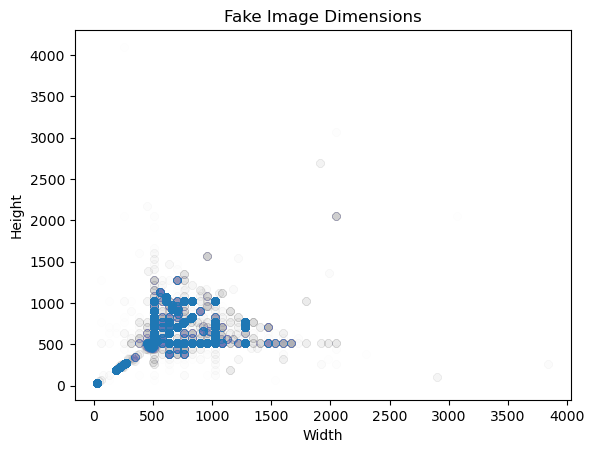

In [59]:
# Plot dimensions of ai-generated images
img_dir = "/Users/jacob/OneDrive/Desktop/Unity Hub/image-dataset/dataset_1/Fake"
plot_image_dimensions(img_dir, heading='Fake Image Dimensions', alpha=0.004)

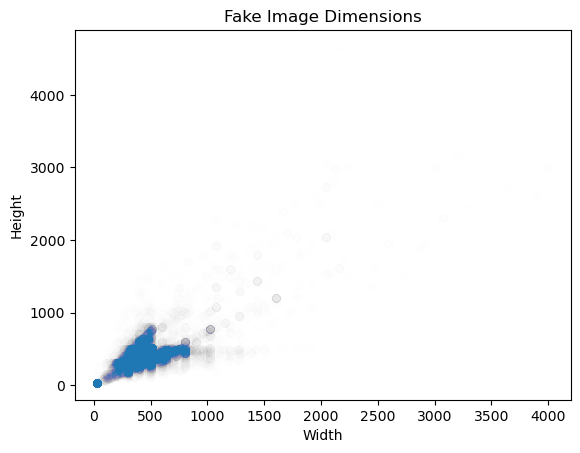

In [60]:
# Plot dimensions of real images
img_dir = "/Users/jacob/OneDrive/Desktop/Unity Hub/image-dataset/dataset_1/Real"
plot_image_dimensions(img_dir, heading='Fake Image Dimensions', alpha=0.004)

## Create Neural Network Architecture
We will reuse the architecture from our face detection model. This architecture includes convolutional layers with residual blocks, followed by fully connected layers for classification.
Using the same architecture allows us to utilize transfer learning.

In [3]:
class ResBlock(nn.Module):
    """
    A residual block that consists of a convolutional block and a skip connection.
    """
    def __init__(self, in_channels, out_channels, dropout_prob=0.3):
        super(ResBlock, self).__init__()
        
        # Define main convolutional block
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob)
        )
        
        # Define skip connection and adapt channels
        self.residual = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
    
    # Pass input through main block and add skip connection
    def forward(self, x):
        out = self.block(x)
        res = self.residual(x)
        return out + res

class AdjustedResCNN(nn.Module):
    """
    This is the architecture of our currently deployed face detection model (Aletheia). 
    We reuse this architceture for this general image detection model (Argus). 
    """
    def __init__(self, dropout_prob=0.3):
        super(AdjustedResCNN, self).__init__()

        # Convolutional layers with residual blocks and max-pooling. The dropout probability is reduced for the convolutional layers
        self.conv_layers = nn.Sequential(
            ResBlock(3, 24, dropout_prob * 0.2),
            nn.MaxPool2d(2),
            ResBlock(24, 48, dropout_prob * 0.2),
            nn.MaxPool2d(2),
            ResBlock(48, 96, dropout_prob * 0.2),
            nn.MaxPool2d(2),
            ResBlock(96, 192, dropout_prob * 0.2),
            nn.MaxPool2d(2)
        )

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(self.feature_size(), 448),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(448, 224),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(224, 112),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(112, 1) # Final layer with one output for our binary classification problem
        )

    def feature_size(self):
        """
        Compute size of flattend features after passing through the convolutional layers.
        This is useful for determining the input size for the fully connected layers
        """
        return self.conv_layers(torch.zeros(1, 3, 224, 224)).view(1, -1).size(1)

    def forward(self, x):
        # Pass input through convolutional layers
        x = self.conv_layers(x)
        # Flatten tensor
        x = x.view(x.size(0), -1) 
        # Pass flattened tensor through fully connected layers
        x = self.fc_layers(x)
        return x

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0.3):
        super(ResBlock, self).__init__()

        # Half the out_channels for each branch
        branch_channels = out_channels // 2

        # 3x3 convolution branch
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, branch_channels, 3, 1, 1),
            nn.BatchNorm2d(branch_channels),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob)
        )

        # 5x5 convolution branch
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(in_channels, branch_channels, 5, 1, 2),  # Padding is 2 to keep the same spatial dimensions
            nn.BatchNorm2d(branch_channels),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob)
        )

        # Define skip connection and adapt channels
        self.residual = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        # Apply both branches
        out3x3 = self.branch3x3(x)
        out5x5 = self.branch5x5(x)

        # Concatenate along channel dimension
        out = torch.cat([out3x3, out5x5], dim=1)

        # Apply the residual connection
        res = self.residual(x)
        return out + res

class NewArgusNet(nn.Module):
    def __init__(self, dropout_prob=0.3):
        super(NewArgusNet, self).__init__()

        # Convolutional layers with residual blocks and max-pooling
        self.conv_layers = nn.Sequential(
            ResBlock(3, 16, dropout_prob * 0.2),
            nn.MaxPool2d(2),
            ResBlock(16, 32, dropout_prob * 0.2),
            nn.MaxPool2d(2),
            ResBlock(32, 64, dropout_prob * 0.2),
            nn.MaxPool2d(2),
            ResBlock(64, 128, dropout_prob * 0.2),
            nn.MaxPool2d(2),
            ResBlock(128, 256, dropout_prob * 0.2)
        )

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(256, 1)
        )

    def feature_size(self):
        return self.conv_layers(torch.zeros(1, 3, 256, 256)).view(1, -1).size(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

## Set Up Device Agnostic Code

In [4]:
# Set the device to GPU if available, else use the CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Hyperparameters

In [5]:
# Define Hyperparameters
num_classes = 2
batch_size = 32
num_epochs = 36

## Data
- Load datasets 
- Split data
- Apply transformations to images and utilize data augmentation

In [6]:
class CustomDataset(Dataset):
    """
    Custom Dataset for loading images with albumentations transforms
    """
    def __init__(self, img_paths, label_list, transform=None):
        self.img_paths = img_paths
        self.label_list = label_list
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img = Image.open(img_path)
        
        # Ensure the image is RGB
        if img.mode != 'RGB':
            img = img.convert('RGB') 
        
        img = np.array(img)
        
        if self.transform:
            augmented = self.transform(image=img)
            img = augmented['image']

        label = self.label_list[index]
        return img, label

### Define Mean and Standard Deviation of Images
Since transfer learning from Aletheia is used, we have to use the normalization values of the Aletheia dataset

In [61]:
from helper_functions import get_image_mean_std
get_image_mean_std('/Users/jacob/OneDrive/Desktop/Unity Hub/image-dataset/dataset_1')

 50%|████▉     | 316/637 [26:49<36:45,  6.87s/it] c:\Users\jacob\miniconda3\envs\env_two\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 637/637 [40:52<00:00,  3.85s/it]


(tensor([0.4709, 0.4373, 0.3948]), tensor([0.2306, 0.2249, 0.2179]))

In [7]:
mean = [0.4709, 0.4373, 0.3948]
std = [0.2306, 0.2249, 0.2179]

### Define Image Transformations
Utilize data augmentation

In [8]:
class AlbumentationsTransform:
    """
    Class to transform images using the Albumentations library
    """
    def __init__(self, transform=None):
        self.transform = transform

    # Apply Albumentations transform to the input image and convert the result to a tensor.
    def __call__(self, img):
        # Convert image to numpy array
        if isinstance(img, Image.Image):
            img = np.array(img)
        
        # Convert augmented image to a tensor and normalize pixel values
        augmented = self.transform(image=img)
        img_tensor = torch.from_numpy(augmented['image'].transpose(2, 0, 1)).float()  / 255.0
        return img_tensor

In [9]:
class TorchvisionBridge:
    """
    Bridge to convert Torchvision transforms into a format that can be used with the Albumentations library.
    """
    def __init__(self, transform):
        self.transform = transform

    # Apply torchvision transformations and convert the results to a numpy array
    def __call__(self, img):
        img = self.transform(img)
        return np.array(img)

In [10]:
# Train Transformations

# Albumentations transformations
train_transform = A.Compose([
    A.HorizontalFlip(p=0.4),
    A.RandomBrightnessContrast(brightness_limit=0.06, contrast_limit=0.06, p=0.3),
    A.Rotate(limit=5, p=0.4),
    A.PixelDropout(dropout_prob=0.015, p=0.3),
    A.Normalize(mean=mean, std=std), 
])
# Torchvision transformations
train_torchvision_transform = transforms.Compose([
    transforms.RandomApply([
        transforms.RandomAffine(degrees=8, translate=(0.10, 0.10))
    ], p=0.5),
    transforms.Resize((256, 256)) 
])

# Test Transformations

# Albumentations transformations
test_transform = A.Compose([
    A.Normalize(mean=mean, std=std), 
])

# Torchvision transformations
test_torchvision_transform = transforms.Compose([
    transforms.Resize((256, 256))
])

# This is used when testing the model on a specific source
test_augmentation = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=mean, std=std)
])

In [11]:
class CustomDataset(Dataset):
    """
    This Custom Dataset class is used to incorporate Torchvision and Albumentation transformations.
    """

    # Initialize CustomDataset Object
    def __init__(self, dataset, torchvision_transforms=None, albumentations_transform=None):
        self.dataset = dataset
        self.torchvision_transforms = torchvision_transforms
        self.albumentations_transform = AlbumentationsTransform(albumentations_transform)

    # Return number of samples in the dataset
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        # Check if dataset is a subset and get the path and target accordingly
        if isinstance(self.dataset, torch.utils.data.Subset):
            path, target = self.dataset.dataset.samples[self.dataset.indices[index]]
        else:
            path, target = self.dataset.samples[index]
        
        img = Image.open(path).convert("RGB")

        # Apply torchvision transforms
        if self.torchvision_transforms:
            img = self.torchvision_transforms(img)
        
        # Apply albumentations transforms
        if self.albumentations_transform:
            img = self.albumentations_transform(img)
        
        return img, target

In [12]:
root_directory = '/Users/jacob/OneDrive/Desktop/Unity Hub/image-dataset/dataset_1'

# Load dataset without transformations
full_dataset = datasets.ImageFolder(root=root_directory)

# Set random seed for reproducibility
torch.manual_seed(3)

# Split dataset into train, validation, and test sets
train_size = int(0.87 * len(full_dataset))  # 87%
validation_size = int(0.04 * len(full_dataset))  # 4%
test_size = len(full_dataset) - train_size - validation_size  # 9%

train_subset, validation_subset, test_subset = random_split(full_dataset, [train_size, validation_size, test_size])

# Apply transformations using the CustomDataset class
train_dataset = CustomDataset(
    train_subset, 
    torchvision_transforms=train_torchvision_transform, 
    albumentations_transform=train_transform
)

# Apply transformations to validation dataset
val_dataset = CustomDataset(
    validation_subset, 
    torchvision_transforms=test_torchvision_transform, 
    albumentations_transform=test_transform
)

# Apply transformations to test dataset
test_dataset = CustomDataset(
    test_subset, 
    torchvision_transforms=test_torchvision_transform, 
    albumentations_transform=test_transform
)


# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## Training

### Prepare Training

In [13]:
from helper_functions import check_accuracy

In [14]:
# Set a random seed for reproducibility
torch.manual_seed(3)

# Initialize model and transfer it to the GPU if available
model = NewArgusNet().to(device)
# Load trained model for transfer learning (from Alteheia 2.5)
# model.load_state_dict(torch.load("C:\\Users\\jacob\\OneDrive\\Desktop\\SyntheticEye\\SyntheticEyeLocal\\StateDicts\\Argus\\Argus2Beta\\ar2_8_no_transfer_epoch_3_correct249670.pth"))
model.to(device)

AdjustedResCNN(
  (conv_layers): Sequential(
    (0): ResBlock(
      (block): Sequential(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
        (3): Dropout(p=0.06, inplace=False)
      )
      (residual): Conv2d(3, 24, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ResBlock(
      (block): Sequential(
        (0): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
        (3): Dropout(p=0.06, inplace=False)
      )
      (residual): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1))
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): ResB

In [15]:
# Use BCEWithLogitsLoss for our binary classification problem
loss_function = nn.BCEWithLogitsLoss()

In [16]:
# Initialize TensorBoard summary writer
writer = SummaryWriter(f'runs/Argus3_0')
step = 0

### Train Model

Using transfer learning and training different layers with different learning rates

In [ ]:
#  Group Layers
early_conv_layers = list(model.conv_layers.children())[:3]  
middle_conv_layers = list(model.conv_layers.children())[3:6]  
fc_layers = list(model.fc_layers.children())

# Create Parameter Groups for different learning rates
param_groups = [
    {'params': chain(*[layer.parameters() for layer in early_conv_layers]), 'lr': 0.000001},
    {'params': chain(*[layer.parameters() for layer in middle_conv_layers]), 'lr': 0.00001},
    {'params': chain(*[layer.parameters() for layer in fc_layers]), 'lr': 0.0001},
]

# Initialize Optimizer with Parameter Groups
optimizer = torch.optim.NAdam(param_groups)
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)
    
# Initialize EmissionsTracker to monitor carbon emissions using CodeCarbon
carbon_tracker = EmissionsTracker(project_name="Argus2_5_Emissions", log_level="critical")
carbon_tracker.start()

# Initialize tracking of correct predictions and total predictions
correct = 0
samples = 0

torch.manual_seed(3)

model = model.to(device)

# Set up log interval for recording metrics
metrics_interval = 200

# Initialize variables for accuracy and loss values
training_loss = 0.0
training_accuracy = 0.0



for epoch in range(num_epochs):
    # Reset accuracy counters at beginning of each epoch
    correct = 0
    samples = 0

    # Switch model to training mode
    model.train()

    # Train model on each batch of train_loader
    for batch_index, (data, targets) in tqdm(enumerate(train_loader), total=len(train_loader), desc="Progress in epoch"):
        # Move data and targets to the device
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Forward pass
        scores = model(data)
        scores = scores.squeeze(1)
        loss = loss_function(scores.view(-1), targets.float())  # Compute loss based on model's predictions

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Convert to binary decisions
        preds = (torch.sigmoid(scores) > 0.5).float()

        # Update accuracy counters
        correct += (preds == targets).sum().item()
        samples += preds.size(0)
        # Calculate accuracy as a percentage
        accuracy = 100 * correct / samples

        if batch_index % metrics_interval == 0:
            # Log metrics to TensorBoard
            writer.add_scalar('Training Loss', loss, epoch * len(train_loader) + batch_index)
            writer.add_scalar('Training Accuracy', accuracy, epoch * len(train_loader) + batch_index)
            # Print metrics
            print("Epoch: ", epoch)
            print(f'Got {correct} / {samples} correct with an accuracy {accuracy:.2f}% on training data.')

    # Update learning rate
    scheduler.step()

    # Print accumulated accuracy for epoch
    print("Epoch: ", epoch)
    print(f'Got {correct} / {samples} correct with accuracy of {accuracy:.2f}% on training data.')

    # Evaluate model on validation set after epoch
    model.eval()
    correct_test, samples_test = check_accuracy(val_loader, model, device)
    test_accuracy = 100 * float(correct_test) / float(samples_test)
    
    # Log test accuracy to TensorBoard
    writer.add_scalar('Test Accuracy', test_accuracy, epoch)
    
    # Save state of model after epoch
    torch.save(model.state_dict(), f'/Users/jacob/OneDrive/Desktop/SyntheticEyeLocal/StateDicts/Argus/Argus2Beta/ar2_5_epoch_{epoch}_correct{correct}.pth')

# Stop EmissionsTracker
emissions = carbon_tracker.stop()

# Display total carbon emissions
print(f"Emissions: {emissions:.6f} kgCO2eq")

# Close TensorBoard writer
writer.close()

### Train Without Transfer Learning
We want to experiment with different methods for training our model

In [17]:
torch.manual_seed(3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = NewArgusNet().to(device)

# Loss function
loss_function = nn.BCEWithLogitsLoss()

# Summary writer for TensorBoard
writer = SummaryWriter(f'runs/ar_3_0')
step = 0

# Initialize Optimizer with single learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.0008)
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

carbon_tracker = EmissionsTracker(project_name="Argus3_0", log_level="critical")
carbon_tracker.start()


# Initialize tracking of correct predictions and total predictions
correct = 0
samples = 0

torch.manual_seed(3)

# model = model.to(device)

# Set up log interval for recording metrics
metrics_interval = 200

# Initialize variables for accuracy and loss values
training_loss = 0.0
training_accuracy = 0.0

if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
for epoch in range(num_epochs):
    # Reset accuracy counters at beginning of each epoch
    correct = 0
    samples = 0

    # Switch model to training mode
    model.train()

    # Train model on each batch of train_loader
    for batch_index, (data, targets) in tqdm(enumerate(train_loader), total=len(train_loader), desc="Progress in epoch"):
        # Move data and targets to the device
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Forward pass
        scores = model(data)
        scores = scores.squeeze(1)
        loss = loss_function(scores.view(-1), targets.float())  # Compute loss based on model's predictions

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Convert to binary decisions
        preds = (torch.sigmoid(scores) > 0.5).float()

        # Update accuracy counters
        correct += (preds == targets).sum().item()
        samples += preds.size(0)
        # Calculate accuracy as a percentage
        accuracy = 100 * correct / samples

        if batch_index % metrics_interval == 0:
            # Log metrics to TensorBoard
            writer.add_scalar('Training Loss', loss, epoch * len(train_loader) + batch_index)
            writer.add_scalar('Training Accuracy', accuracy, epoch * len(train_loader) + batch_index)
            # Print metrics
            print("Epoch: ", epoch)
            print(f'Got {correct} / {samples} correct with an accuracy {accuracy:.2f}% on training data.')

    # Update learning rate
    scheduler.step()

    # Print accumulated accuracy for epoch
    print("Epoch: ", epoch)
    print(f'Got {correct} / {samples} correct with accuracy of {accuracy:.2f}% on training data.')

    # Evaluate model on validation set after epoch
    model.eval()
    correct_test, samples_test = check_accuracy(val_loader, model, device)
    test_accuracy = 100 * float(correct_test) / float(samples_test)
    
    # Log test accuracy to TensorBoard
    writer.add_scalar('Test Accuracy', test_accuracy, epoch)
    
    # Save state of model after epoch
    torch.save(model.state_dict(), f'/Users/jacob/OneDrive/Desktop/SyntheticEye/SyntheticEyeLocal/StateDicts/Argus/ar3_0_epoch_{epoch}_correct{correct}.pth')


emissions = carbon_tracker.stop()
print(f"Emissions: {emissions:.6f} kgCO2eq")
writer.close()

Progress in epoch:   0%|          | 0/8796 [00:00<?, ?it/s]

Epoch:  0
Got 26 / 32 correct with an accuracy 81.25% on training data.
Epoch:  0
Got 5720 / 6432 correct with an accuracy 88.93% on training data.
Epoch:  0
Got 11386 / 12832 correct with an accuracy 88.73% on training data.
Epoch:  0
Got 17024 / 19232 correct with an accuracy 88.52% on training data.
Epoch:  0
Got 22639 / 25632 correct with an accuracy 88.32% on training data.
Epoch:  0
Got 28310 / 32032 correct with an accuracy 88.38% on training data.
Epoch:  0
Got 33958 / 38432 correct with an accuracy 88.36% on training data.
Epoch:  0
Got 39624 / 44832 correct with an accuracy 88.38% on training data.
Epoch:  0
Got 45268 / 51232 correct with an accuracy 88.36% on training data.


c:\Users\jacob\miniconda3\envs\env_two\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch:  0
Got 50914 / 57632 correct with an accuracy 88.34% on training data.
Epoch:  0
Got 56662 / 64032 correct with an accuracy 88.49% on training data.
Epoch:  0
Got 62228 / 70432 correct with an accuracy 88.35% on training data.
Epoch:  0
Got 67915 / 76832 correct with an accuracy 88.39% on training data.
Epoch:  0
Got 73571 / 83232 correct with an accuracy 88.39% on training data.
Epoch:  0
Got 79165 / 89632 correct with an accuracy 88.32% on training data.
Epoch:  0
Got 84843 / 96032 correct with an accuracy 88.35% on training data.
Epoch:  0
Got 90488 / 102432 correct with an accuracy 88.34% on training data.
Epoch:  0
Got 96167 / 108832 correct with an accuracy 88.36% on training data.
Epoch:  0
Got 101779 / 115232 correct with an accuracy 88.33% on training data.
Epoch:  0
Got 107342 / 121632 correct with an accuracy 88.25% on training data.
Epoch:  0
Got 112984 / 128032 correct with an accuracy 88.25% on training data.
Epoch:  0
Got 118631 / 134432 correct with an accuracy 8

100%|██████████| 518/518 [02:47<00:00,  3.10it/s]


Got 14345 / 16556 correct with an accuracy of 86.65%


Progress in epoch:   0%|          | 0/8796 [00:00<?, ?it/s]

Epoch:  1
Got 26 / 32 correct with an accuracy 81.25% on training data.
Epoch:  1
Got 5678 / 6432 correct with an accuracy 88.28% on training data.
Epoch:  1
Got 11482 / 12832 correct with an accuracy 89.48% on training data.
Epoch:  1
Got 17186 / 19232 correct with an accuracy 89.36% on training data.
Epoch:  1
Got 22929 / 25632 correct with an accuracy 89.45% on training data.
Epoch:  1
Got 28535 / 32032 correct with an accuracy 89.08% on training data.
Epoch:  1
Got 34201 / 38432 correct with an accuracy 88.99% on training data.
Epoch:  1
Got 39862 / 44832 correct with an accuracy 88.91% on training data.
Epoch:  1
Got 45540 / 51232 correct with an accuracy 88.89% on training data.
Epoch:  1
Got 51123 / 57632 correct with an accuracy 88.71% on training data.
Epoch:  1
Got 56846 / 64032 correct with an accuracy 88.78% on training data.
Epoch:  1
Got 62460 / 70432 correct with an accuracy 88.68% on training data.
Epoch:  1
Got 67989 / 76832 correct with an accuracy 88.49% on training 

100%|██████████| 518/518 [02:47<00:00,  3.09it/s]


Got 14414 / 16556 correct with an accuracy of 87.06%


Progress in epoch:   0%|          | 0/8796 [00:00<?, ?it/s]

Epoch:  2
Got 29 / 32 correct with an accuracy 90.62% on training data.
Epoch:  2
Got 5694 / 6432 correct with an accuracy 88.53% on training data.
Epoch:  2
Got 11395 / 12832 correct with an accuracy 88.80% on training data.
Epoch:  2
Got 16960 / 19232 correct with an accuracy 88.19% on training data.
Epoch:  2
Got 22381 / 25632 correct with an accuracy 87.32% on training data.
Epoch:  2
Got 27985 / 32032 correct with an accuracy 87.37% on training data.
Epoch:  2
Got 33631 / 38432 correct with an accuracy 87.51% on training data.
Epoch:  2
Got 39319 / 44832 correct with an accuracy 87.70% on training data.
Epoch:  2
Got 44953 / 51232 correct with an accuracy 87.74% on training data.
Epoch:  2
Got 50653 / 57632 correct with an accuracy 87.89% on training data.
Epoch:  2
Got 56375 / 64032 correct with an accuracy 88.04% on training data.
Epoch:  2
Got 62076 / 70432 correct with an accuracy 88.14% on training data.
Epoch:  2
Got 67772 / 76832 correct with an accuracy 88.21% on training 

100%|██████████| 518/518 [02:48<00:00,  3.07it/s]


Got 14825 / 16556 correct with an accuracy of 89.54%


Progress in epoch:   0%|          | 0/8796 [00:00<?, ?it/s]

Epoch:  3
Got 32 / 32 correct with an accuracy 100.00% on training data.
Epoch:  3
Got 5788 / 6432 correct with an accuracy 89.99% on training data.
Epoch:  3
Got 11539 / 12832 correct with an accuracy 89.92% on training data.
Epoch:  3
Got 17258 / 19232 correct with an accuracy 89.74% on training data.
Epoch:  3
Got 23056 / 25632 correct with an accuracy 89.95% on training data.
Epoch:  3
Got 28834 / 32032 correct with an accuracy 90.02% on training data.
Epoch:  3
Got 34440 / 38432 correct with an accuracy 89.61% on training data.
Epoch:  3
Got 40062 / 44832 correct with an accuracy 89.36% on training data.
Epoch:  3
Got 45723 / 51232 correct with an accuracy 89.25% on training data.
Epoch:  3
Got 51483 / 57632 correct with an accuracy 89.33% on training data.
Epoch:  3
Got 57174 / 64032 correct with an accuracy 89.29% on training data.
Epoch:  3
Got 62903 / 70432 correct with an accuracy 89.31% on training data.
Epoch:  3
Got 68642 / 76832 correct with an accuracy 89.34% on training

100%|██████████| 518/518 [02:48<00:00,  3.07it/s]


Got 13588 / 16556 correct with an accuracy of 82.07%


Progress in epoch:   0%|          | 0/8796 [00:00<?, ?it/s]

Epoch:  4
Got 29 / 32 correct with an accuracy 90.62% on training data.
Epoch:  4
Got 5771 / 6432 correct with an accuracy 89.72% on training data.
Epoch:  4
Got 11550 / 12832 correct with an accuracy 90.01% on training data.
Epoch:  4
Got 17278 / 19232 correct with an accuracy 89.84% on training data.
Epoch:  4
Got 23075 / 25632 correct with an accuracy 90.02% on training data.
Epoch:  4
Got 28813 / 32032 correct with an accuracy 89.95% on training data.
Epoch:  4
Got 34597 / 38432 correct with an accuracy 90.02% on training data.
Epoch:  4
Got 40391 / 44832 correct with an accuracy 90.09% on training data.
Epoch:  4
Got 46176 / 51232 correct with an accuracy 90.13% on training data.
Epoch:  4
Got 51917 / 57632 correct with an accuracy 90.08% on training data.
Epoch:  4
Got 57632 / 64032 correct with an accuracy 90.00% on training data.
Epoch:  4
Got 63390 / 70432 correct with an accuracy 90.00% on training data.
Epoch:  4
Got 69184 / 76832 correct with an accuracy 90.05% on training 

100%|██████████| 518/518 [03:15<00:00,  2.65it/s]


Got 14299 / 16556 correct with an accuracy of 86.37%


Progress in epoch:   0%|          | 0/8796 [00:00<?, ?it/s]

Epoch:  5
Got 28 / 32 correct with an accuracy 87.50% on training data.
Epoch:  5
Got 5778 / 6432 correct with an accuracy 89.83% on training data.
Epoch:  5
Got 11583 / 12832 correct with an accuracy 90.27% on training data.
Epoch:  5
Got 17352 / 19232 correct with an accuracy 90.22% on training data.
Epoch:  5
Got 23123 / 25632 correct with an accuracy 90.21% on training data.
Epoch:  5
Got 28926 / 32032 correct with an accuracy 90.30% on training data.
Epoch:  5
Got 34696 / 38432 correct with an accuracy 90.28% on training data.
Epoch:  5
Got 40257 / 44832 correct with an accuracy 89.80% on training data.
Epoch:  5
Got 46026 / 51232 correct with an accuracy 89.84% on training data.
Epoch:  5
Got 51776 / 57632 correct with an accuracy 89.84% on training data.
Epoch:  5
Got 57612 / 64032 correct with an accuracy 89.97% on training data.
Epoch:  5
Got 63410 / 70432 correct with an accuracy 90.03% on training data.
Epoch:  5
Got 69198 / 76832 correct with an accuracy 90.06% on training 

100%|██████████| 518/518 [03:14<00:00,  2.66it/s]


Got 14714 / 16556 correct with an accuracy of 88.87%


Progress in epoch:   0%|          | 0/8796 [00:00<?, ?it/s]

Epoch:  6
Got 29 / 32 correct with an accuracy 90.62% on training data.
Epoch:  6
Got 5789 / 6432 correct with an accuracy 90.00% on training data.
Epoch:  6
Got 11538 / 12832 correct with an accuracy 89.92% on training data.
Epoch:  6
Got 17330 / 19232 correct with an accuracy 90.11% on training data.
Epoch:  6
Got 23145 / 25632 correct with an accuracy 90.30% on training data.
Epoch:  6
Got 29000 / 32032 correct with an accuracy 90.53% on training data.
Epoch:  6
Got 34839 / 38432 correct with an accuracy 90.65% on training data.
Epoch:  6
Got 40636 / 44832 correct with an accuracy 90.64% on training data.
Epoch:  6
Got 46434 / 51232 correct with an accuracy 90.63% on training data.
Epoch:  6
Got 52272 / 57632 correct with an accuracy 90.70% on training data.
Epoch:  6
Got 57961 / 64032 correct with an accuracy 90.52% on training data.
Epoch:  6
Got 63702 / 70432 correct with an accuracy 90.44% on training data.
Epoch:  6
Got 69487 / 76832 correct with an accuracy 90.44% on training 

100%|██████████| 518/518 [03:09<00:00,  2.73it/s]


Got 14430 / 16556 correct with an accuracy of 87.16%


Progress in epoch:   0%|          | 0/8796 [00:00<?, ?it/s]

Epoch:  7
Got 26 / 32 correct with an accuracy 81.25% on training data.
Epoch:  7
Got 5833 / 6432 correct with an accuracy 90.69% on training data.
Epoch:  7
Got 11670 / 12832 correct with an accuracy 90.94% on training data.
Epoch:  7
Got 17534 / 19232 correct with an accuracy 91.17% on training data.
Epoch:  7
Got 23341 / 25632 correct with an accuracy 91.06% on training data.
Epoch:  7
Got 29204 / 32032 correct with an accuracy 91.17% on training data.
Epoch:  7
Got 35023 / 38432 correct with an accuracy 91.13% on training data.
Epoch:  7
Got 40866 / 44832 correct with an accuracy 91.15% on training data.
Epoch:  7
Got 46693 / 51232 correct with an accuracy 91.14% on training data.
Epoch:  7
Got 52443 / 57632 correct with an accuracy 91.00% on training data.
Epoch:  7
Got 58257 / 64032 correct with an accuracy 90.98% on training data.
Epoch:  7
Got 64081 / 70432 correct with an accuracy 90.98% on training data.
Epoch:  7
Got 69927 / 76832 correct with an accuracy 91.01% on training 

100%|██████████| 518/518 [03:15<00:00,  2.65it/s]


Got 14394 / 16556 correct with an accuracy of 86.94%


Progress in epoch:   0%|          | 0/8796 [00:00<?, ?it/s]

Epoch:  8
Got 25 / 32 correct with an accuracy 78.12% on training data.
Epoch:  8
Got 5904 / 6432 correct with an accuracy 91.79% on training data.
Epoch:  8
Got 11725 / 12832 correct with an accuracy 91.37% on training data.
Epoch:  8
Got 17606 / 19232 correct with an accuracy 91.55% on training data.
Epoch:  8
Got 23470 / 25632 correct with an accuracy 91.57% on training data.
Epoch:  8
Got 29297 / 32032 correct with an accuracy 91.46% on training data.
Epoch:  8
Got 35106 / 38432 correct with an accuracy 91.35% on training data.
Epoch:  8
Got 40927 / 44832 correct with an accuracy 91.29% on training data.
Epoch:  8
Got 46747 / 51232 correct with an accuracy 91.25% on training data.
Epoch:  8
Got 52642 / 57632 correct with an accuracy 91.34% on training data.
Epoch:  8
Got 58486 / 64032 correct with an accuracy 91.34% on training data.
Epoch:  8
Got 64317 / 70432 correct with an accuracy 91.32% on training data.
Epoch:  8
Got 70123 / 76832 correct with an accuracy 91.27% on training 

100%|██████████| 518/518 [03:15<00:00,  2.65it/s]


Got 15108 / 16556 correct with an accuracy of 91.25%


Progress in epoch:   0%|          | 0/8796 [00:00<?, ?it/s]

Epoch:  9
Got 29 / 32 correct with an accuracy 90.62% on training data.
Epoch:  9
Got 5867 / 6432 correct with an accuracy 91.22% on training data.
Epoch:  9
Got 11741 / 12832 correct with an accuracy 91.50% on training data.
Epoch:  9
Got 17614 / 19232 correct with an accuracy 91.59% on training data.
Epoch:  9
Got 23500 / 25632 correct with an accuracy 91.68% on training data.
Epoch:  9
Got 29382 / 32032 correct with an accuracy 91.73% on training data.
Epoch:  9
Got 35263 / 38432 correct with an accuracy 91.75% on training data.
Epoch:  9
Got 41108 / 44832 correct with an accuracy 91.69% on training data.
Epoch:  9
Got 46990 / 51232 correct with an accuracy 91.72% on training data.
Epoch:  9
Got 52886 / 57632 correct with an accuracy 91.76% on training data.
Epoch:  9
Got 58733 / 64032 correct with an accuracy 91.72% on training data.
Epoch:  9
Got 64606 / 70432 correct with an accuracy 91.73% on training data.
Epoch:  9
Got 70516 / 76832 correct with an accuracy 91.78% on training 

100%|██████████| 518/518 [02:50<00:00,  3.03it/s]


Got 15269 / 16556 correct with an accuracy of 92.23%


Progress in epoch:   0%|          | 0/8796 [00:00<?, ?it/s]

Epoch:  10
Got 32 / 32 correct with an accuracy 100.00% on training data.
Epoch:  10
Got 5908 / 6432 correct with an accuracy 91.85% on training data.
Epoch:  10
Got 11807 / 12832 correct with an accuracy 92.01% on training data.
Epoch:  10
Got 17708 / 19232 correct with an accuracy 92.08% on training data.
Epoch:  10
Got 23606 / 25632 correct with an accuracy 92.10% on training data.
Epoch:  10
Got 29497 / 32032 correct with an accuracy 92.09% on training data.
Epoch:  10
Got 35382 / 38432 correct with an accuracy 92.06% on training data.
Epoch:  10
Got 41176 / 44832 correct with an accuracy 91.85% on training data.
Epoch:  10
Got 46946 / 51232 correct with an accuracy 91.63% on training data.
Epoch:  10
Got 52856 / 57632 correct with an accuracy 91.71% on training data.
Epoch:  10
Got 58757 / 64032 correct with an accuracy 91.76% on training data.
Epoch:  10
Got 64626 / 70432 correct with an accuracy 91.76% on training data.
Epoch:  10
Got 70501 / 76832 correct with an accuracy 91.76

100%|██████████| 518/518 [02:49<00:00,  3.06it/s]


Got 14791 / 16556 correct with an accuracy of 89.34%


Progress in epoch:   0%|          | 0/8796 [00:00<?, ?it/s]

Epoch:  11
Got 30 / 32 correct with an accuracy 93.75% on training data.
Epoch:  11
Got 5940 / 6432 correct with an accuracy 92.35% on training data.
Epoch:  11
Got 11841 / 12832 correct with an accuracy 92.28% on training data.
Epoch:  11
Got 17741 / 19232 correct with an accuracy 92.25% on training data.
Epoch:  11
Got 23666 / 25632 correct with an accuracy 92.33% on training data.
Epoch:  11
Got 29605 / 32032 correct with an accuracy 92.42% on training data.
Epoch:  11
Got 35479 / 38432 correct with an accuracy 92.32% on training data.
Epoch:  11
Got 41415 / 44832 correct with an accuracy 92.38% on training data.
Epoch:  11
Got 47284 / 51232 correct with an accuracy 92.29% on training data.
Epoch:  11
Got 53221 / 57632 correct with an accuracy 92.35% on training data.
Epoch:  11
Got 59155 / 64032 correct with an accuracy 92.38% on training data.
Epoch:  11
Got 65089 / 70432 correct with an accuracy 92.41% on training data.
Epoch:  11
Got 70970 / 76832 correct with an accuracy 92.37%

100%|██████████| 518/518 [02:49<00:00,  3.05it/s]


Got 15394 / 16556 correct with an accuracy of 92.98%


Progress in epoch:   0%|          | 0/8796 [00:00<?, ?it/s]

Epoch:  12
Got 28 / 32 correct with an accuracy 87.50% on training data.
Epoch:  12
Got 5967 / 6432 correct with an accuracy 92.77% on training data.
Epoch:  12
Got 11871 / 12832 correct with an accuracy 92.51% on training data.
Epoch:  12
Got 17821 / 19232 correct with an accuracy 92.66% on training data.
Epoch:  12
Got 23759 / 25632 correct with an accuracy 92.69% on training data.
Epoch:  12
Got 29659 / 32032 correct with an accuracy 92.59% on training data.
Epoch:  12
Got 35588 / 38432 correct with an accuracy 92.60% on training data.
Epoch:  12
Got 41518 / 44832 correct with an accuracy 92.61% on training data.
Epoch:  12
Got 47411 / 51232 correct with an accuracy 92.54% on training data.
Epoch:  12
Got 53340 / 57632 correct with an accuracy 92.55% on training data.
Epoch:  12
Got 59230 / 64032 correct with an accuracy 92.50% on training data.
Epoch:  12
Got 65126 / 70432 correct with an accuracy 92.47% on training data.
Epoch:  12
Got 71066 / 76832 correct with an accuracy 92.50%

100%|██████████| 518/518 [02:50<00:00,  3.03it/s]


Got 15365 / 16556 correct with an accuracy of 92.81%


Progress in epoch:   0%|          | 0/8796 [00:00<?, ?it/s]

Epoch:  13
Got 30 / 32 correct with an accuracy 93.75% on training data.
Epoch:  13
Got 5928 / 6432 correct with an accuracy 92.16% on training data.
Epoch:  13
Got 11908 / 12832 correct with an accuracy 92.80% on training data.
Epoch:  13
Got 17824 / 19232 correct with an accuracy 92.68% on training data.
Epoch:  13
Got 23837 / 25632 correct with an accuracy 93.00% on training data.
Epoch:  13
Got 29711 / 32032 correct with an accuracy 92.75% on training data.
Epoch:  13
Got 35652 / 38432 correct with an accuracy 92.77% on training data.
Epoch:  13
Got 41578 / 44832 correct with an accuracy 92.74% on training data.
Epoch:  13
Got 47503 / 51232 correct with an accuracy 92.72% on training data.
Epoch:  13
Got 53422 / 57632 correct with an accuracy 92.70% on training data.
Epoch:  13
Got 59349 / 64032 correct with an accuracy 92.69% on training data.
Epoch:  13
Got 65287 / 70432 correct with an accuracy 92.70% on training data.
Epoch:  13
Got 71174 / 76832 correct with an accuracy 92.64%

100%|██████████| 518/518 [02:50<00:00,  3.03it/s]


Got 14556 / 16556 correct with an accuracy of 87.92%


Progress in epoch:   0%|          | 0/8796 [00:00<?, ?it/s]

Epoch:  14
Got 27 / 32 correct with an accuracy 84.38% on training data.
Epoch:  14
Got 5967 / 6432 correct with an accuracy 92.77% on training data.
Epoch:  14
Got 11908 / 12832 correct with an accuracy 92.80% on training data.
Epoch:  14
Got 17696 / 19232 correct with an accuracy 92.01% on training data.
Epoch:  14
Got 23566 / 25632 correct with an accuracy 91.94% on training data.
Epoch:  14
Got 29472 / 32032 correct with an accuracy 92.01% on training data.
Epoch:  14
Got 35432 / 38432 correct with an accuracy 92.19% on training data.
Epoch:  14
Got 41398 / 44832 correct with an accuracy 92.34% on training data.
Epoch:  14
Got 47296 / 51232 correct with an accuracy 92.32% on training data.
Epoch:  14
Got 53098 / 57632 correct with an accuracy 92.13% on training data.
Epoch:  14
Got 58995 / 64032 correct with an accuracy 92.13% on training data.
Epoch:  14
Got 64901 / 70432 correct with an accuracy 92.15% on training data.
Epoch:  14
Got 70826 / 76832 correct with an accuracy 92.18%

100%|██████████| 518/518 [03:00<00:00,  2.87it/s]


Got 15027 / 16556 correct with an accuracy of 90.76%


Progress in epoch:   0%|          | 0/8796 [00:00<?, ?it/s]

Epoch:  15
Got 28 / 32 correct with an accuracy 87.50% on training data.
Epoch:  15
Got 5978 / 6432 correct with an accuracy 92.94% on training data.
Epoch:  15
Got 11931 / 12832 correct with an accuracy 92.98% on training data.
Epoch:  15
Got 17886 / 19232 correct with an accuracy 93.00% on training data.
Epoch:  15
Got 23817 / 25632 correct with an accuracy 92.92% on training data.
Epoch:  15
Got 29708 / 32032 correct with an accuracy 92.74% on training data.
Epoch:  15
Got 35629 / 38432 correct with an accuracy 92.71% on training data.
Epoch:  15
Got 41599 / 44832 correct with an accuracy 92.79% on training data.
Epoch:  15
Got 47553 / 51232 correct with an accuracy 92.82% on training data.
Epoch:  15
Got 53520 / 57632 correct with an accuracy 92.87% on training data.
Epoch:  15
Got 59464 / 64032 correct with an accuracy 92.87% on training data.
Epoch:  15
Got 65439 / 70432 correct with an accuracy 92.91% on training data.
Epoch:  15
Got 71413 / 76832 correct with an accuracy 92.95%

100%|██████████| 518/518 [03:00<00:00,  2.88it/s]


Got 15417 / 16556 correct with an accuracy of 93.12%


Progress in epoch:   0%|          | 0/8796 [00:00<?, ?it/s]

Epoch:  16
Got 30 / 32 correct with an accuracy 93.75% on training data.
Epoch:  16
Got 5965 / 6432 correct with an accuracy 92.74% on training data.
Epoch:  16
Got 11944 / 12832 correct with an accuracy 93.08% on training data.
Epoch:  16
Got 17880 / 19232 correct with an accuracy 92.97% on training data.
Epoch:  16
Got 23833 / 25632 correct with an accuracy 92.98% on training data.
Epoch:  16
Got 29825 / 32032 correct with an accuracy 93.11% on training data.
Epoch:  16
Got 35766 / 38432 correct with an accuracy 93.06% on training data.
Epoch:  16
Got 41742 / 44832 correct with an accuracy 93.11% on training data.
Epoch:  16
Got 47714 / 51232 correct with an accuracy 93.13% on training data.
Epoch:  16
Got 53679 / 57632 correct with an accuracy 93.14% on training data.
Epoch:  16
Got 59673 / 64032 correct with an accuracy 93.19% on training data.
Epoch:  16
Got 65660 / 70432 correct with an accuracy 93.22% on training data.
Epoch:  16
Got 71648 / 76832 correct with an accuracy 93.25%

100%|██████████| 518/518 [03:02<00:00,  2.84it/s]


Got 15549 / 16556 correct with an accuracy of 93.92%


Progress in epoch:   0%|          | 0/8796 [00:00<?, ?it/s]

Epoch:  17
Got 30 / 32 correct with an accuracy 93.75% on training data.
Epoch:  17
Got 5990 / 6432 correct with an accuracy 93.13% on training data.
Epoch:  17
Got 11979 / 12832 correct with an accuracy 93.35% on training data.
Epoch:  17
Got 17926 / 19232 correct with an accuracy 93.21% on training data.
Epoch:  17
Got 23924 / 25632 correct with an accuracy 93.34% on training data.
Epoch:  17
Got 29933 / 32032 correct with an accuracy 93.45% on training data.
Epoch:  17
Got 35909 / 38432 correct with an accuracy 93.44% on training data.
Epoch:  17
Got 41871 / 44832 correct with an accuracy 93.40% on training data.
Epoch:  17
Got 47860 / 51232 correct with an accuracy 93.42% on training data.
Epoch:  17
Got 53834 / 57632 correct with an accuracy 93.41% on training data.
Epoch:  17
Got 59810 / 64032 correct with an accuracy 93.41% on training data.
Epoch:  17
Got 65791 / 70432 correct with an accuracy 93.41% on training data.
Epoch:  17
Got 71793 / 76832 correct with an accuracy 93.44%

100%|██████████| 518/518 [03:00<00:00,  2.87it/s]


Got 15451 / 16556 correct with an accuracy of 93.33%


Progress in epoch:   0%|          | 0/8796 [00:00<?, ?it/s]

Epoch:  18
Got 29 / 32 correct with an accuracy 90.62% on training data.
Epoch:  18
Got 5997 / 6432 correct with an accuracy 93.24% on training data.
Epoch:  18
Got 11918 / 12832 correct with an accuracy 92.88% on training data.
Epoch:  18
Got 17883 / 19232 correct with an accuracy 92.99% on training data.
Epoch:  18
Got 23854 / 25632 correct with an accuracy 93.06% on training data.
Epoch:  18
Got 29831 / 32032 correct with an accuracy 93.13% on training data.
Epoch:  18
Got 35810 / 38432 correct with an accuracy 93.18% on training data.
Epoch:  18
Got 41795 / 44832 correct with an accuracy 93.23% on training data.
Epoch:  18
Got 47759 / 51232 correct with an accuracy 93.22% on training data.
Epoch:  18
Got 53732 / 57632 correct with an accuracy 93.23% on training data.
Epoch:  18
Got 59707 / 64032 correct with an accuracy 93.25% on training data.
Epoch:  18
Got 65701 / 70432 correct with an accuracy 93.28% on training data.
Epoch:  18
Got 71671 / 76832 correct with an accuracy 93.28%

100%|██████████| 518/518 [02:48<00:00,  3.07it/s]


Got 15556 / 16556 correct with an accuracy of 93.96%


Progress in epoch:   0%|          | 0/8796 [00:00<?, ?it/s]

Epoch:  19
Got 29 / 32 correct with an accuracy 90.62% on training data.
Epoch:  19
Got 6005 / 6432 correct with an accuracy 93.36% on training data.
Epoch:  19
Got 11980 / 12832 correct with an accuracy 93.36% on training data.
Epoch:  19
Got 17935 / 19232 correct with an accuracy 93.26% on training data.
Epoch:  19
Got 23923 / 25632 correct with an accuracy 93.33% on training data.
Epoch:  19
Got 29932 / 32032 correct with an accuracy 93.44% on training data.
Epoch:  19
Got 35912 / 38432 correct with an accuracy 93.44% on training data.
Epoch:  19
Got 41905 / 44832 correct with an accuracy 93.47% on training data.
Epoch:  19
Got 47923 / 51232 correct with an accuracy 93.54% on training data.
Epoch:  19
Got 53917 / 57632 correct with an accuracy 93.55% on training data.
Epoch:  19
Got 59919 / 64032 correct with an accuracy 93.58% on training data.
Epoch:  19
Got 65890 / 70432 correct with an accuracy 93.55% on training data.
Epoch:  19
Got 71862 / 76832 correct with an accuracy 93.53%

100%|██████████| 518/518 [02:47<00:00,  3.09it/s]


Got 15542 / 16556 correct with an accuracy of 93.88%


Progress in epoch:   0%|          | 0/8796 [00:00<?, ?it/s]

Epoch:  20
Got 29 / 32 correct with an accuracy 90.62% on training data.
Epoch:  20
Got 6029 / 6432 correct with an accuracy 93.73% on training data.
Epoch:  20
Got 11989 / 12832 correct with an accuracy 93.43% on training data.
Epoch:  20
Got 17981 / 19232 correct with an accuracy 93.50% on training data.
Epoch:  20
Got 23995 / 25632 correct with an accuracy 93.61% on training data.
Epoch:  20
Got 29959 / 32032 correct with an accuracy 93.53% on training data.
Epoch:  20
Got 35955 / 38432 correct with an accuracy 93.55% on training data.
Epoch:  20
Got 41969 / 44832 correct with an accuracy 93.61% on training data.
Epoch:  20
Got 47942 / 51232 correct with an accuracy 93.58% on training data.
Epoch:  20
Got 53939 / 57632 correct with an accuracy 93.59% on training data.
Epoch:  20
Got 59960 / 64032 correct with an accuracy 93.64% on training data.
Epoch:  20
Got 65955 / 70432 correct with an accuracy 93.64% on training data.
Epoch:  20
Got 71981 / 76832 correct with an accuracy 93.69%

100%|██████████| 518/518 [02:43<00:00,  3.16it/s]


Got 15453 / 16556 correct with an accuracy of 93.34%


Progress in epoch:   0%|          | 0/8796 [00:00<?, ?it/s]

Epoch:  21
Got 32 / 32 correct with an accuracy 100.00% on training data.
Epoch:  21
Got 6001 / 6432 correct with an accuracy 93.30% on training data.
Epoch:  21
Got 11984 / 12832 correct with an accuracy 93.39% on training data.
Epoch:  21
Got 18012 / 19232 correct with an accuracy 93.66% on training data.
Epoch:  21
Got 24012 / 25632 correct with an accuracy 93.68% on training data.
Epoch:  21
Got 29992 / 32032 correct with an accuracy 93.63% on training data.
Epoch:  21
Got 35985 / 38432 correct with an accuracy 93.63% on training data.
Epoch:  21
Got 42022 / 44832 correct with an accuracy 93.73% on training data.
Epoch:  21
Got 48025 / 51232 correct with an accuracy 93.74% on training data.
Epoch:  21
Got 54051 / 57632 correct with an accuracy 93.79% on training data.
Epoch:  21
Got 60038 / 64032 correct with an accuracy 93.76% on training data.
Epoch:  21
Got 66059 / 70432 correct with an accuracy 93.79% on training data.
Epoch:  21
Got 72077 / 76832 correct with an accuracy 93.81

100%|██████████| 518/518 [02:45<00:00,  3.13it/s]


Got 15580 / 16556 correct with an accuracy of 94.10%


Progress in epoch:   0%|          | 0/8796 [00:00<?, ?it/s]

Epoch:  22
Got 30 / 32 correct with an accuracy 93.75% on training data.
Epoch:  22
Got 6080 / 6432 correct with an accuracy 94.53% on training data.
Epoch:  22
Got 12046 / 12832 correct with an accuracy 93.87% on training data.
Epoch:  22
Got 18059 / 19232 correct with an accuracy 93.90% on training data.
Epoch:  22
Got 24082 / 25632 correct with an accuracy 93.95% on training data.
Epoch:  22
Got 30085 / 32032 correct with an accuracy 93.92% on training data.
Epoch:  22
Got 36100 / 38432 correct with an accuracy 93.93% on training data.
Epoch:  22
Got 42080 / 44832 correct with an accuracy 93.86% on training data.
Epoch:  22
Got 48108 / 51232 correct with an accuracy 93.90% on training data.
Epoch:  22
Got 54078 / 57632 correct with an accuracy 93.83% on training data.
Epoch:  22
Got 60106 / 64032 correct with an accuracy 93.87% on training data.
Epoch:  22
Got 66125 / 70432 correct with an accuracy 93.88% on training data.
Epoch:  22
Got 72114 / 76832 correct with an accuracy 93.86%

100%|██████████| 518/518 [02:45<00:00,  3.14it/s]


Got 15555 / 16556 correct with an accuracy of 93.95%


Progress in epoch:   0%|          | 0/8796 [00:00<?, ?it/s]

Epoch:  23
Got 29 / 32 correct with an accuracy 90.62% on training data.
Epoch:  23
Got 6026 / 6432 correct with an accuracy 93.69% on training data.
Epoch:  23
Got 11997 / 12832 correct with an accuracy 93.49% on training data.
Epoch:  23
Got 17988 / 19232 correct with an accuracy 93.53% on training data.
Epoch:  23
Got 23986 / 25632 correct with an accuracy 93.58% on training data.
Epoch:  23
Got 30014 / 32032 correct with an accuracy 93.70% on training data.
Epoch:  23
Got 36029 / 38432 correct with an accuracy 93.75% on training data.
Epoch:  23
Got 42075 / 44832 correct with an accuracy 93.85% on training data.
Epoch:  23
Got 48121 / 51232 correct with an accuracy 93.93% on training data.
Epoch:  23
Got 54113 / 57632 correct with an accuracy 93.89% on training data.
Epoch:  23
Got 60140 / 64032 correct with an accuracy 93.92% on training data.
Epoch:  23
Got 66139 / 70432 correct with an accuracy 93.90% on training data.
Epoch:  23
Got 72094 / 76832 correct with an accuracy 93.83%

100%|██████████| 518/518 [02:45<00:00,  3.12it/s]


Got 15616 / 16556 correct with an accuracy of 94.32%


Progress in epoch:   0%|          | 0/8796 [00:00<?, ?it/s]

Epoch:  24
Got 29 / 32 correct with an accuracy 90.62% on training data.
Epoch:  24
Got 6042 / 6432 correct with an accuracy 93.94% on training data.
Epoch:  24
Got 12034 / 12832 correct with an accuracy 93.78% on training data.
Epoch:  24
Got 18053 / 19232 correct with an accuracy 93.87% on training data.
Epoch:  24
Got 24090 / 25632 correct with an accuracy 93.98% on training data.
Epoch:  24
Got 30084 / 32032 correct with an accuracy 93.92% on training data.
Epoch:  24
Got 36115 / 38432 correct with an accuracy 93.97% on training data.
Epoch:  24
Got 42148 / 44832 correct with an accuracy 94.01% on training data.
Epoch:  24
Got 48178 / 51232 correct with an accuracy 94.04% on training data.
Epoch:  24
Got 54209 / 57632 correct with an accuracy 94.06% on training data.
Epoch:  24
Got 60225 / 64032 correct with an accuracy 94.05% on training data.
Epoch:  24
Got 66236 / 70432 correct with an accuracy 94.04% on training data.
Epoch:  24
Got 72239 / 76832 correct with an accuracy 94.02%

100%|██████████| 518/518 [02:44<00:00,  3.14it/s]


Got 15615 / 16556 correct with an accuracy of 94.32%


Progress in epoch:   0%|          | 0/8796 [00:00<?, ?it/s]

Epoch:  25
Got 31 / 32 correct with an accuracy 96.88% on training data.
Epoch:  25
Got 6046 / 6432 correct with an accuracy 94.00% on training data.
Epoch:  25
Got 12069 / 12832 correct with an accuracy 94.05% on training data.
Epoch:  25
Got 18070 / 19232 correct with an accuracy 93.96% on training data.
Epoch:  25
Got 24110 / 25632 correct with an accuracy 94.06% on training data.
Epoch:  25
Got 30123 / 32032 correct with an accuracy 94.04% on training data.
Epoch:  25
Got 36168 / 38432 correct with an accuracy 94.11% on training data.
Epoch:  25
Got 42158 / 44832 correct with an accuracy 94.04% on training data.
Epoch:  25
Got 48181 / 51232 correct with an accuracy 94.04% on training data.
Epoch:  25
Got 54217 / 57632 correct with an accuracy 94.07% on training data.
Epoch:  25
Got 60198 / 64032 correct with an accuracy 94.01% on training data.
Epoch:  25
Got 66213 / 70432 correct with an accuracy 94.01% on training data.
Epoch:  25
Got 72210 / 76832 correct with an accuracy 93.98%

100%|██████████| 518/518 [02:44<00:00,  3.14it/s]


Got 15320 / 16556 correct with an accuracy of 92.53%


Progress in epoch:   0%|          | 0/8796 [00:00<?, ?it/s]

Epoch:  26
Got 29 / 32 correct with an accuracy 90.62% on training data.
Epoch:  26
Got 6064 / 6432 correct with an accuracy 94.28% on training data.
Epoch:  26
Got 12074 / 12832 correct with an accuracy 94.09% on training data.
Epoch:  26
Got 18089 / 19232 correct with an accuracy 94.06% on training data.
Epoch:  26
Got 24127 / 25632 correct with an accuracy 94.13% on training data.
Epoch:  26
Got 30141 / 32032 correct with an accuracy 94.10% on training data.
Epoch:  26
Got 36181 / 38432 correct with an accuracy 94.14% on training data.
Epoch:  26
Got 42185 / 44832 correct with an accuracy 94.10% on training data.
Epoch:  26
Got 48217 / 51232 correct with an accuracy 94.12% on training data.
Epoch:  26
Got 54256 / 57632 correct with an accuracy 94.14% on training data.
Epoch:  26
Got 60267 / 64032 correct with an accuracy 94.12% on training data.
Epoch:  26
Got 66294 / 70432 correct with an accuracy 94.12% on training data.
Epoch:  26
Got 72329 / 76832 correct with an accuracy 94.14%

100%|██████████| 518/518 [02:46<00:00,  3.11it/s]


Got 15642 / 16556 correct with an accuracy of 94.48%


Progress in epoch:   0%|          | 0/8796 [00:00<?, ?it/s]

Epoch:  27
Got 30 / 32 correct with an accuracy 93.75% on training data.
Epoch:  27
Got 6076 / 6432 correct with an accuracy 94.47% on training data.
Epoch:  27
Got 12083 / 12832 correct with an accuracy 94.16% on training data.
Epoch:  27
Got 18122 / 19232 correct with an accuracy 94.23% on training data.
Epoch:  27
Got 24153 / 25632 correct with an accuracy 94.23% on training data.
Epoch:  27
Got 30186 / 32032 correct with an accuracy 94.24% on training data.
Epoch:  27
Got 36205 / 38432 correct with an accuracy 94.21% on training data.
Epoch:  27
Got 42219 / 44832 correct with an accuracy 94.17% on training data.
Epoch:  27
Got 48265 / 51232 correct with an accuracy 94.21% on training data.
Epoch:  27
Got 54312 / 57632 correct with an accuracy 94.24% on training data.
Epoch:  27
Got 60336 / 64032 correct with an accuracy 94.23% on training data.
Epoch:  27
Got 66375 / 70432 correct with an accuracy 94.24% on training data.
Epoch:  27
Got 72382 / 76832 correct with an accuracy 94.21%

100%|██████████| 518/518 [02:44<00:00,  3.15it/s]

Got 15562 / 16556 correct with an accuracy of 94.00%


Progress in epoch:   0%|          | 0/8796 [00:00<?, ?it/s]

Epoch:  28
Got 32 / 32 correct with an accuracy 100.00% on training data.
Epoch:  28
Got 6044 / 6432 correct with an accuracy 93.97% on training data.
Epoch:  28
Got 12123 / 12832 correct with an accuracy 94.47% on training data.
Epoch:  28
Got 18158 / 19232 correct with an accuracy 94.42% on training data.
Epoch:  28
Got 24208 / 25632 correct with an accuracy 94.44% on training data.
Epoch:  28
Got 30222 / 32032 correct with an accuracy 94.35% on training data.
Epoch:  28
Got 36191 / 38432 correct with an accuracy 94.17% on training data.
Epoch:  28
Got 42193 / 44832 correct with an accuracy 94.11% on training data.
Epoch:  28
Got 48223 / 51232 correct with an accuracy 94.13% on training data.
Epoch:  28
Got 54236 / 57632 correct with an accuracy 94.11% on training data.
Epoch:  28
Got 60262 / 64032 correct with an accuracy 94.11% on training data.
Epoch:  28
Got 66301 / 70432 correct with an accuracy 94.13% on training data.
Epoch:  28
Got 72366 / 76832 correct with an accuracy 94.19

100%|██████████| 518/518 [02:48<00:00,  3.07it/s]


Got 15679 / 16556 correct with an accuracy of 94.70%


Progress in epoch:   0%|          | 0/8796 [00:00<?, ?it/s]

Epoch:  29
Got 30 / 32 correct with an accuracy 93.75% on training data.
Epoch:  29
Got 6079 / 6432 correct with an accuracy 94.51% on training data.
Epoch:  29
Got 12095 / 12832 correct with an accuracy 94.26% on training data.
Epoch:  29
Got 18125 / 19232 correct with an accuracy 94.24% on training data.
Epoch:  29
Got 24154 / 25632 correct with an accuracy 94.23% on training data.
Epoch:  29
Got 30159 / 32032 correct with an accuracy 94.15% on training data.
Epoch:  29
Got 36154 / 38432 correct with an accuracy 94.07% on training data.
Epoch:  29
Got 42156 / 44832 correct with an accuracy 94.03% on training data.
Epoch:  29
Got 48196 / 51232 correct with an accuracy 94.07% on training data.
Epoch:  29
Got 54212 / 57632 correct with an accuracy 94.07% on training data.
Epoch:  29
Got 60250 / 64032 correct with an accuracy 94.09% on training data.
Epoch:  29
Got 66288 / 70432 correct with an accuracy 94.12% on training data.
Epoch:  29
Got 72364 / 76832 correct with an accuracy 94.18%

100%|██████████| 518/518 [02:46<00:00,  3.11it/s]


Got 15655 / 16556 correct with an accuracy of 94.56%


Progress in epoch:   0%|          | 0/8796 [00:00<?, ?it/s]

Epoch:  30
Got 29 / 32 correct with an accuracy 90.62% on training data.
Epoch:  30
Got 6103 / 6432 correct with an accuracy 94.88% on training data.
Epoch:  30
Got 12092 / 12832 correct with an accuracy 94.23% on training data.
Epoch:  30
Got 18135 / 19232 correct with an accuracy 94.30% on training data.
Epoch:  30
Got 24164 / 25632 correct with an accuracy 94.27% on training data.
Epoch:  30
Got 30229 / 32032 correct with an accuracy 94.37% on training data.
Epoch:  30
Got 36262 / 38432 correct with an accuracy 94.35% on training data.
Epoch:  30
Got 42322 / 44832 correct with an accuracy 94.40% on training data.
Epoch:  30
Got 48369 / 51232 correct with an accuracy 94.41% on training data.
Epoch:  30
Got 54416 / 57632 correct with an accuracy 94.42% on training data.
Epoch:  30
Got 60453 / 64032 correct with an accuracy 94.41% on training data.
Epoch:  30
Got 66444 / 70432 correct with an accuracy 94.34% on training data.
Epoch:  30
Got 72429 / 76832 correct with an accuracy 94.27%

100%|██████████| 518/518 [02:49<00:00,  3.05it/s]


Got 15729 / 16556 correct with an accuracy of 95.00%


Progress in epoch:   0%|          | 0/8796 [00:00<?, ?it/s]

Epoch:  31
Got 32 / 32 correct with an accuracy 100.00% on training data.
Epoch:  31
Got 6086 / 6432 correct with an accuracy 94.62% on training data.
Epoch:  31
Got 12100 / 12832 correct with an accuracy 94.30% on training data.
Epoch:  31
Got 18147 / 19232 correct with an accuracy 94.36% on training data.
Epoch:  31
Got 24164 / 25632 correct with an accuracy 94.27% on training data.
Epoch:  31
Got 30195 / 32032 correct with an accuracy 94.27% on training data.
Epoch:  31
Got 36238 / 38432 correct with an accuracy 94.29% on training data.
Epoch:  31
Got 42294 / 44832 correct with an accuracy 94.34% on training data.
Epoch:  31
Got 48333 / 51232 correct with an accuracy 94.34% on training data.
Epoch:  31
Got 54347 / 57632 correct with an accuracy 94.30% on training data.
Epoch:  31
Got 60392 / 64032 correct with an accuracy 94.32% on training data.
Epoch:  31
Got 66470 / 70432 correct with an accuracy 94.37% on training data.
Epoch:  31
Got 72513 / 76832 correct with an accuracy 94.38

100%|██████████| 518/518 [02:52<00:00,  3.00it/s]


Got 15684 / 16556 correct with an accuracy of 94.73%


Progress in epoch:   0%|          | 0/8796 [00:00<?, ?it/s]

Epoch:  32
Got 29 / 32 correct with an accuracy 90.62% on training data.
Epoch:  32
Got 6074 / 6432 correct with an accuracy 94.43% on training data.
Epoch:  32
Got 12144 / 12832 correct with an accuracy 94.64% on training data.
Epoch:  32
Got 18184 / 19232 correct with an accuracy 94.55% on training data.
Epoch:  32
Got 24203 / 25632 correct with an accuracy 94.42% on training data.
Epoch:  32
Got 30267 / 32032 correct with an accuracy 94.49% on training data.
Epoch:  32
Got 36319 / 38432 correct with an accuracy 94.50% on training data.
Epoch:  32
Got 42372 / 44832 correct with an accuracy 94.51% on training data.
Epoch:  32
Got 48407 / 51232 correct with an accuracy 94.49% on training data.
Epoch:  32
Got 54456 / 57632 correct with an accuracy 94.49% on training data.
Epoch:  32
Got 60487 / 64032 correct with an accuracy 94.46% on training data.
Epoch:  32
Got 66537 / 70432 correct with an accuracy 94.47% on training data.
Epoch:  32
Got 72578 / 76832 correct with an accuracy 94.46%

100%|██████████| 518/518 [03:01<00:00,  2.85it/s]


Got 15711 / 16556 correct with an accuracy of 94.90%


Progress in epoch:   0%|          | 0/8796 [00:00<?, ?it/s]

Epoch:  33
Got 30 / 32 correct with an accuracy 93.75% on training data.
Epoch:  33
Got 6097 / 6432 correct with an accuracy 94.79% on training data.
Epoch:  33
Got 12147 / 12832 correct with an accuracy 94.66% on training data.
Epoch:  33
Got 18205 / 19232 correct with an accuracy 94.66% on training data.
Epoch:  33
Got 24276 / 25632 correct with an accuracy 94.71% on training data.
Epoch:  33
Got 30321 / 32032 correct with an accuracy 94.66% on training data.
Epoch:  33
Got 36389 / 38432 correct with an accuracy 94.68% on training data.
Epoch:  33
Got 42456 / 44832 correct with an accuracy 94.70% on training data.
Epoch:  33
Got 48540 / 51232 correct with an accuracy 94.75% on training data.
Epoch:  33
Got 54571 / 57632 correct with an accuracy 94.69% on training data.
Epoch:  33
Got 60609 / 64032 correct with an accuracy 94.65% on training data.
Epoch:  33
Got 66646 / 70432 correct with an accuracy 94.62% on training data.
Epoch:  33
Got 72699 / 76832 correct with an accuracy 94.62%

100%|██████████| 518/518 [03:00<00:00,  2.88it/s]

Got 15689 / 16556 correct with an accuracy of 94.76%


Progress in epoch:   0%|          | 0/8796 [00:00<?, ?it/s]

Epoch:  34
Got 27 / 32 correct with an accuracy 84.38% on training data.
Epoch:  34
Got 6089 / 6432 correct with an accuracy 94.67% on training data.
Epoch:  34
Got 12129 / 12832 correct with an accuracy 94.52% on training data.
Epoch:  34
Got 18170 / 19232 correct with an accuracy 94.48% on training data.
Epoch:  34
Got 24201 / 25632 correct with an accuracy 94.42% on training data.
Epoch:  34
Got 30232 / 32032 correct with an accuracy 94.38% on training data.
Epoch:  34
Got 36294 / 38432 correct with an accuracy 94.44% on training data.
Epoch:  34
Got 42343 / 44832 correct with an accuracy 94.45% on training data.
Epoch:  34
Got 48394 / 51232 correct with an accuracy 94.46% on training data.
Epoch:  34
Got 54455 / 57632 correct with an accuracy 94.49% on training data.
Epoch:  34
Got 60469 / 64032 correct with an accuracy 94.44% on training data.
Epoch:  34
Got 66539 / 70432 correct with an accuracy 94.47% on training data.
Epoch:  34
Got 72573 / 76832 correct with an accuracy 94.46%

100%|██████████| 518/518 [03:00<00:00,  2.87it/s]


Got 15697 / 16556 correct with an accuracy of 94.81%


Progress in epoch:   0%|          | 0/8796 [00:00<?, ?it/s]

Epoch:  35
Got 30 / 32 correct with an accuracy 93.75% on training data.
Epoch:  35
Got 6107 / 6432 correct with an accuracy 94.95% on training data.
Epoch:  35
Got 12203 / 12832 correct with an accuracy 95.10% on training data.
Epoch:  35
Got 18234 / 19232 correct with an accuracy 94.81% on training data.
Epoch:  35
Got 24306 / 25632 correct with an accuracy 94.83% on training data.
Epoch:  35
Got 30343 / 32032 correct with an accuracy 94.73% on training data.
Epoch:  35
Got 36364 / 38432 correct with an accuracy 94.62% on training data.
Epoch:  35
Got 42416 / 44832 correct with an accuracy 94.61% on training data.
Epoch:  35
Got 48490 / 51232 correct with an accuracy 94.65% on training data.
Epoch:  35
Got 54518 / 57632 correct with an accuracy 94.60% on training data.
Epoch:  35
Got 60591 / 64032 correct with an accuracy 94.63% on training data.
Epoch:  35
Got 66636 / 70432 correct with an accuracy 94.61% on training data.
Epoch:  35
Got 72694 / 76832 correct with an accuracy 94.61%

100%|██████████| 518/518 [03:00<00:00,  2.87it/s]


Got 15704 / 16556 correct with an accuracy of 94.85%
Emissions: 0.600474 kgCO2eq


## Test Model

In [52]:
model = NewArgusNet().to(device)

# Create a dummy input and perform a forward pass to create the fc1 layer
sample_input = torch.randn(1, 3, 224, 224).to(device)
model(sample_input)

# Specify path to the trained model weights
model_path = "C:\\Users\\jacob\\OneDrive\\Desktop\\SyntheticEye\\SyntheticEyeLocal\\StateDicts\\Argus\\Argus2Beta\\ar2_8_no_transfer_epoch_30_correct265582.pth"

# Load trained weights into the model
model.load_state_dict(torch.load(model_path))

model = model.to(device)

In [44]:
check_accuracy(test_loader, model, device)

<class 'torch.utils.data.dataloader.DataLoader'>


100%|██████████| 1035/1035 [05:12<00:00,  3.31it/s]

Got 31713 / 33115 correct with an accuracy of 95.77%


(31713, 33115)

In [27]:
from helper_functions import predict_single_image

In [30]:
img_path = "/Users/jacob/OneDrive/Desktop/FakeCar.jpg"
predicted_label = predict_single_image(
    img_path, 
    model,
    # Use Albumentations to transform the image
    AlbumentationsTransform(test_augmentation)
)
print(f"Predicted probability for image: {predicted_label}")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jacob/OneDrive/Desktop/FakeCar.jpg'

### Test on Specific Source

In [51]:
# Load the new dataset
new_root_directory = "C:\\Users\\jacob\\OneDrive\\Dalle3Eval"

new_full_dataset = datasets.ImageFolder(root=new_root_directory)

# Apply data augmentation and images transformations

new_test_dataset = CustomDataset(
    new_full_dataset, 
    albumentations_transform=test_augmentation
)

# Create a DataLoader for the new dataset
new_test_loader = DataLoader(new_test_dataset, batch_size=batch_size, shuffle=False)

# Evaluate accuracy on new dataset
check_accuracy(new_test_loader, model, device)

<class 'torch.utils.data.dataloader.DataLoader'>


  0%|          | 0/51 [00:00<?, ?it/s]

100%|██████████| 51/51 [00:22<00:00,  2.25it/s]

Got 1346 / 1606 correct with an accuracy of 83.81%


(1346, 1606)

In [25]:
def single_image_transforms():
    """
    Combine torchvision and albumentations transforms for an individual image
    """

    tv_transform = tv_transform = TorchvisionBridge(torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224))]))
    alb_transform = AlbumentationsTransform(test_augmentation)
    
    # Apply both transformations to the given image
    def combined_transforms(img):
        img = tv_transform(img)
        return alb_transform(img)
    
    return combined_transforms

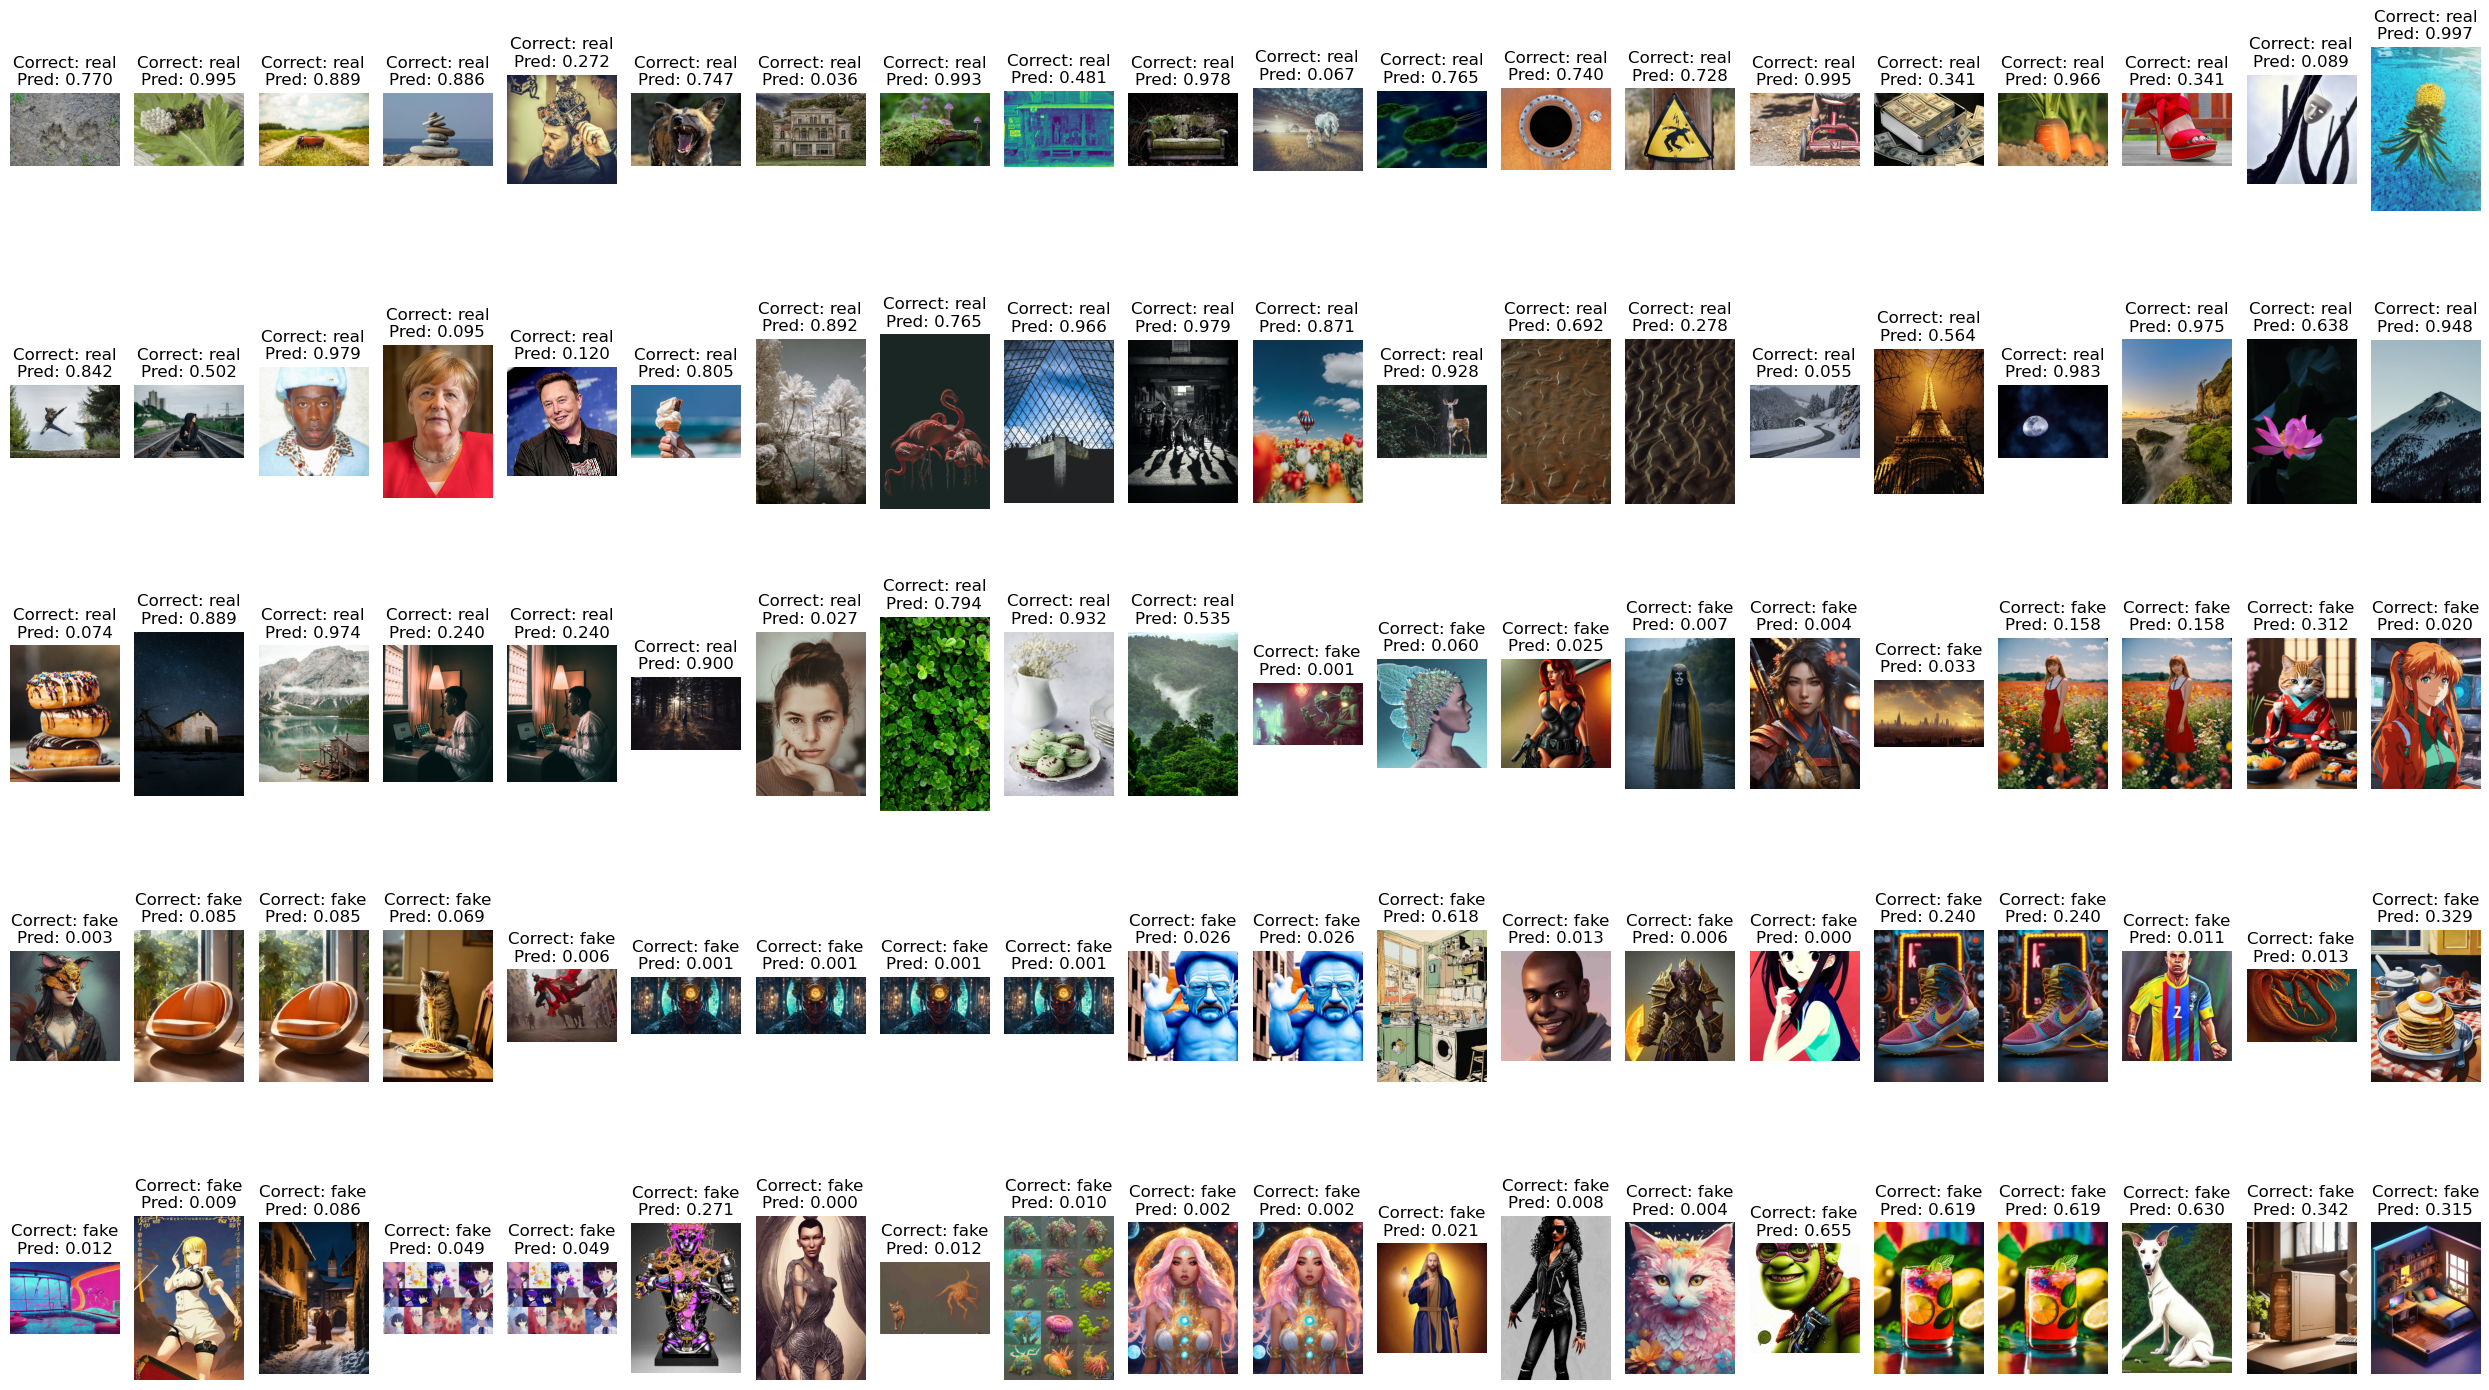

In [26]:
# Import function for displaying predictions on multiple images
from helper_functions import display_folder_images
# Load combined transformations and display images with their predicted probabilities
combined_transforms = single_image_transforms()
display_folder_images("/Users/jacob/OneDrive/ArgusMultipleEval", model, combined_transforms)